In [4]:
import sys, os, re, gzip, json, pickle, shutil, random

import numpy as np
import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

#from fse.models import SIF
#from fse import IndexedList

from pydub.utils import mediainfo
from pydub import AudioSegment

import librosa
import librosa.display

import soundfile as sf

from PIL import Image

%matplotlib inline

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [6]:
#import sys
#!{sys.executable} -m pip install --upgrade gensim==3.8.3
#!{sys.executable} -m pip install fse
#!{sys.executable} -m pip install fse

In [7]:
data_path = '../data'
mp3com_path = '%s/mp3_com' % data_path

myspace_path = '%s/myspace_mp3s' % data_path
metadata_path = '%s/metadata.json.gz' % myspace_path
genre_map_path = '%s/genre_map.pkl' % myspace_path

features_path = '%s/audio_features' % data_path
melspec_path = '%s/melspec' % features_path

In [8]:
def get_sample_sounds(feature_path, files_per_genre=100, samples_per_file=100, genres=[]):
    x = []
    
    if not genres:
        genres = [g for g in os.listdir(feature_path) if not '.' in g]
    
    for genre in genres:
        genre_path = '%s/%s' % (feature_path, genre)
        
        fns = [fn for fn in os.listdir(genre_path) if fn.endswith('.npy')]
        random.shuffle(fns)
        print(len(fns))
        
        for fn in fns[:files_per_genre]:
            fp = '%s/%s' % (genre_path, fn)
            x_feat = np.load(fp).T
            
            idx = np.arange(x_feat.shape[0])
            np.random.shuffle(idx)
            
            for ix in idx[:samples_per_file]:
                x.append(x_feat[ix, :])
                
        print('On %s - samples so far: %d' % (genre, len(x)))
    
    return np.vstack(x)

In [9]:
x = get_sample_sounds(melspec_path, files_per_genre=100, samples_per_file=100)
x.shape

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../data/audio_features/melspec'

In [164]:
for num_clusters in [16, 32, 64, 128, 256, 512, 1024]:
    clusterer = KMeans(n_clusters=num_clusters)
    cluster_labels = clusterer.fit_predict(x[:10000])
    silhouette_avg = silhouette_score(x[:10000], cluster_labels)
    print(num_clusters, silhouette_avg)
    
#16 0.36242262
#32 0.29464215
#64 0.2453676
#128 0.19619666
#256 0.20118718
#512 0.12762408
#1024 0.12945075

16 0.36242262
32 0.29464215
64 0.2453676
128 0.19619666
256 0.20118718
512 0.12762408
1024 0.12945075


In [157]:
svd = TruncatedSVD(n_components=32, n_iter=10)
x_svd32 = svd.fit_transform(x)
sum(svd.explained_variance_ratio_)

0.9844398915302008

In [163]:
for num_clusters in [16, 32, 64, 128, 256, 512, 1024]:
    clusterer = KMeans(n_clusters=num_clusters)
    cluster_labels = clusterer.fit_predict(x_svd32[:10000])
    silhouette_avg = silhouette_score(x_svd32[:10000], cluster_labels)
    print(num_clusters, silhouette_avg)
    
#16 0.40616554
#32 0.2761832
#64 0.27561525
#256 0.16004406
#512 0.1358941
#1024 0.1434426

16 0.40616554
32 0.2761832
64 0.27561525
256 0.16004406
512 0.1358941
1024 0.1434426


In [ ]:
class MusicLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, sound_vocab_size, out_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.sound_embeddings = nn.Embedding(sound_vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hid_out = nn.Linear(hidden_dim, out_size)

    def forward(self, sound_idx):
        embeds = self.word_embeddings(sound_idx)
        lstm_out, _ = self.lstm(embeds.view(len(sound_idx), 1, -1))
        out = self.hid_out(lstm_out.view(len(sound_idx), -1))
        out = F.log_softmax(out, dim=1)
        return out

In [ ]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)
    print(tag_scores)

for epoch in range(300):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

# See what the scores are after training
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)

    # The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
    # for word i. The predicted tag is the maximum scoring tag.
    # Here, we can see the predicted sequence below is 0 1 2 0 1
    # since 0 is index of the maximum value of row 1,
    # 1 is the index of maximum value of row 2, etc.
    # Which is DET NOUN VERB DET NOUN, the correct sequence!
    print(tag_scores)

In [142]:
#sample_path = '%s/Beethoven_Sonata_No_8_.mp3' % mp3com_path
#sample_path = '%s/Non_Sequitur_I.mp3' % mp3com_path
#sample_path = '%s/Be_With_Me.mp3' % mp3com_path
#sample_path = '%s/Beautiful_Sky.mp3' % mp3com_path
#sample_path = '%s/pink_noise.mp3' % data_path
#sample_path = '%s/BEINGS_FROM_A_STRANGE_.mp3' % mp3com_path #synth techno
#sample_path = 'humble3.wav'
sample_path = '%s/Waiting_for_Connor.mp3' % mp3com_path

In [143]:
x, sr = librosa.load(sample_path)
x.shape, sr #6935040 = 5min14s, 13386816=10m7s

((13386816,), 22050)

In [140]:
#melspec = librosa.feature.melspectrogram(x, sr=sr, n_mels=1024, n_fft=2048, fmin=20, fmax=16000)
#256 sounds okay, 512 is better
melspec = librosa.feature.melspectrogram(x, sr=sr, n_mels=128, n_fft=2048, hop_length=512) # fmin=20, fmax=16000)
melspec.shape

(128, 13546)

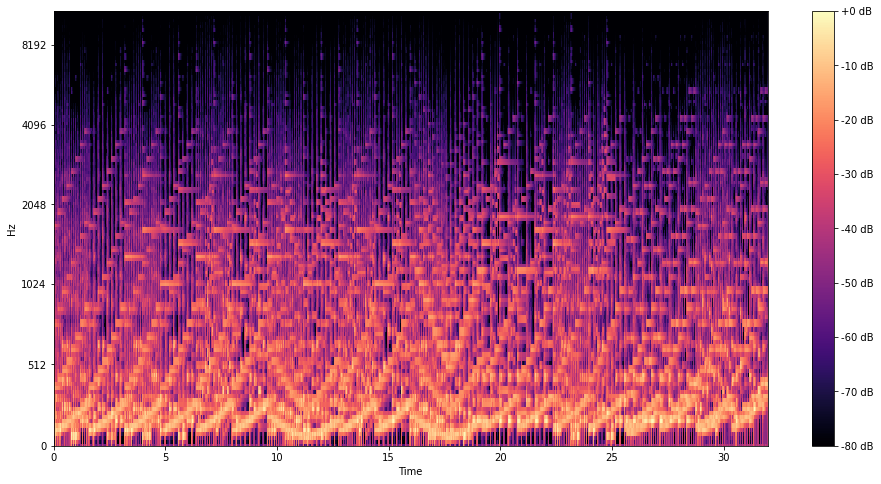

In [135]:
fig, ax = plt.subplots(figsize=(16,8))
#melspec_db = librosa.amplitude_to_db(np.abs(melspec), ref=np.max)
melspec_db = librosa.power_to_db(np.abs(melspec), ref=np.max)
img = librosa.display.specshow(melspec_db, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [136]:
import time
start = time.time()
n_fft=2048
n_iter=32
melspec_x = librosa.feature.inverse.mel_to_audio(melspec[:,:1000], sr=sr, n_fft=n_fft, n_iter=n_iter)
sf.write('mel128_to_audio.wav', melspec_x, sr, 'PCM_24')
print((time.time()-start)/60)

7.159445707003275


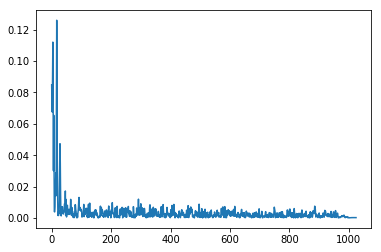

In [104]:
n_fft = 2048
stft_n_fft = np.abs(librosa.stft(x[n_fft*100:n_fft*101], n_fft=n_fft, hop_length=n_fft+1))
plt.plot(stft_n_fft);

In [85]:
mfcc = librosa.feature.mfcc(x, sr=sr)#, n_mfcc=20)
mfcc.shape

(20, 13546)

In [99]:
hop_length=512
x_chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
x_chromagram.shape

(12, 25063)

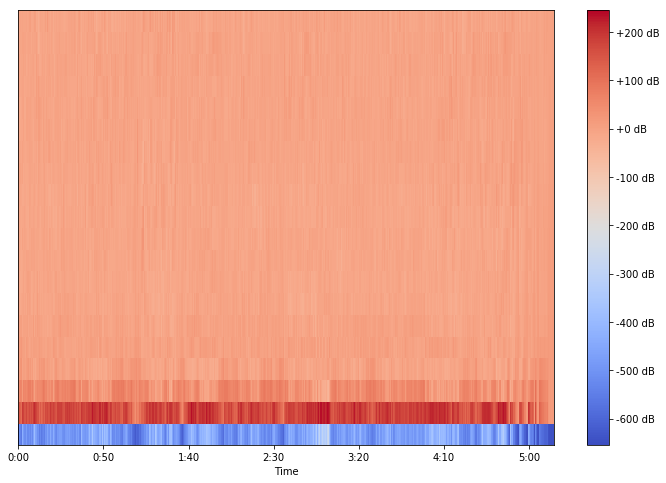

In [86]:
fig, ax = plt.subplots(figsize=(12,8))
img = librosa.display.specshow(mfcc, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [15]:
prev_ms = melspec[:,0]
for i in range(1,13):
    ms = melspec[:,i*1000]
    dif = np.sum(np.power((ms-prev_ms), 2))
    print(dif, ms)

0.017766882 [1.4072148e-03 2.0308865e-03 1.7755268e-02 7.4749880e-02 2.8448723e-02
 1.9311102e-02 2.3387887e-02 2.1122400e-02 2.2631800e-02 4.5717347e-02
 2.3022447e-02 1.4511843e-02 2.1918168e-02 5.0699618e-02 2.4404315e-02
 5.0051130e-02 3.7802900e-03 1.0006725e-03 5.5867981e-04 2.6664976e-04
 4.2337347e-03 8.3315913e-03 8.0443965e-03 1.4436631e-03 5.4812193e-05
 5.1763398e-04 1.8297366e-03 3.7480131e-04 6.9602422e-04 1.8112739e-03
 2.8520965e-03 6.7307439e-04 1.6657932e-05 4.9885261e-05 4.2096923e-05
 8.9496811e-05 9.2947920e-04 1.6727487e-03 6.2369283e-05 1.5617006e-05
 2.4772341e-06 3.1639316e-05 5.8964717e-05 3.4517722e-04 3.2310057e-04
 9.1051425e-06 1.4622683e-05 5.6200965e-06 9.8887795e-05 8.8657362e-05
 6.4594942e-06 9.3543031e-06 8.1928183e-06 3.3385099e-05 8.9101577e-06
 1.1817431e-05 2.3362466e-06 3.1097730e-07 6.5537097e-07 3.0963423e-07
 3.2662581e-06 4.0875975e-06 1.2806490e-07 2.1854373e-07 3.6550514e-07
 6.8896588e-06 1.8661417e-06 1.3237153e-07 1.3849638e-07 8.499717

In [17]:
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering

In [18]:
cluster_model = AgglomerativeClustering(n_clusters=1000, affinity='euclidean', linkage='average')
cluster_model = cluster_model.fit(melspec.T)

In [24]:
labs = [l for l in cluster_model.labels_ if not l==16]
len(labs)

5045

(array([0.00206351, 0.00422623, 0.01944462, 0.00119049, 0.0010516 ,
        0.00255955, 0.00194446, 0.00130954, 0.00275796, 0.00263891,
        0.00255955, 0.00250002, 0.00113096, 0.00063493, 0.00075397,
        0.00150795, 0.0013889 , 0.00216272, 0.00093255, 0.0011508 ,
        0.00059524, 0.0018651 , 0.00083334, 0.00275796, 0.00055556,
        0.0003373 , 0.00039683, 0.00027778, 0.00710324, 0.00045635,
        0.0003373 , 0.00051588, 0.00027778, 0.00035715, 0.00031746,
        0.00097223, 0.00140874, 0.00031746, 0.00093255, 0.00041667,
        0.00093255, 0.00047619, 0.0011508 , 0.00079366, 0.00132938,
        0.00255955, 0.00035715, 0.00224208, 0.00031746, 0.00067461,
        0.00019841, 0.00021826, 0.00021826, 0.00021826, 0.0003373 ,
        0.00019841, 0.0002381 , 0.00019841, 0.00021826, 0.00019841,
        0.00019841, 0.00019841, 0.00021826, 0.0002381 , 0.00019841,
        0.00021826, 0.00019841, 0.00021826, 0.00019841, 0.00019841,
        0.0002381 , 0.00025794, 0.00027778, 0.00

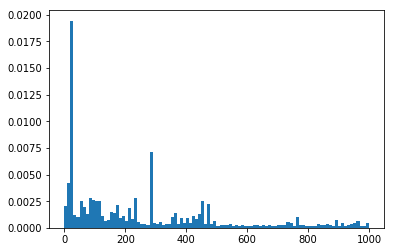

In [25]:
plt.hist(labs, density=True, bins=100)

In [157]:
components=2
perp=30
n_iter=1000

tsne = TSNE(n_components=components, verbose=1, perplexity=perp, n_iter=n_iter)
tsne_results = tsne.fit_transform(melspec.T)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13546 samples in 0.572s...
[t-SNE] Computed neighbors for 13546 samples in 74.555s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13546
[t-SNE] Computed conditional probabilities for sample 2000 / 13546
[t-SNE] Computed conditional probabilities for sample 3000 / 13546
[t-SNE] Computed conditional probabilities for sample 4000 / 13546
[t-SNE] Computed conditional probabilities for sample 5000 / 13546
[t-SNE] Computed conditional probabilities for sample 6000 / 13546
[t-SNE] Computed conditional probabilities for sample 7000 / 13546
[t-SNE] Computed conditional probabilities for sample 8000 / 13546
[t-SNE] Computed conditional probabilities for sample 9000 / 13546
[t-SNE] Computed conditional probabilities for sample 10000 / 13546
[t-SNE] Computed conditional probabilities for sample 11000 / 13546
[t-SNE] Computed conditional probabilities for sample 12000 / 13546
[t-SNE] Computed conditional probabilities for sa

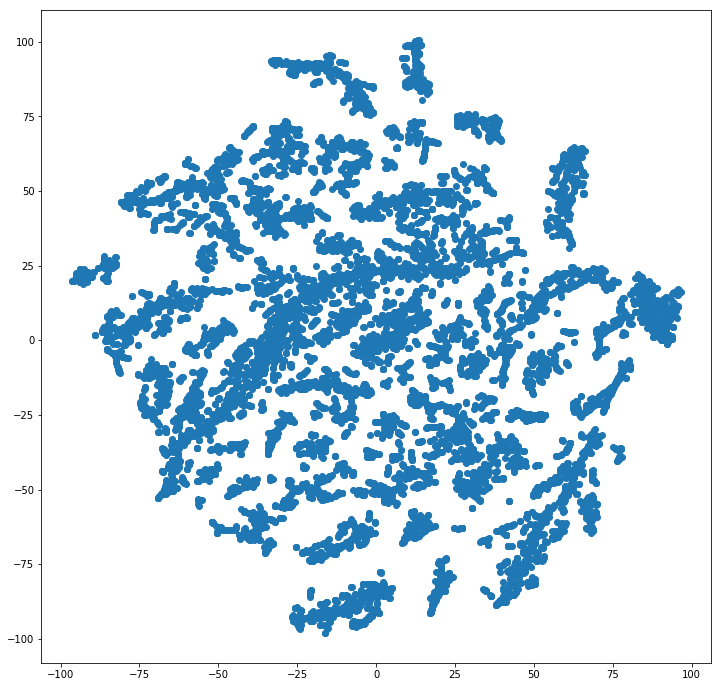

In [158]:
vis_x = tsne_results[:,0]
vis_y = tsne_results[:,1]
plt.figure(figsize=(12,12))
plt.scatter(vis_x, vis_y)
plt.show()

In [29]:
from sklearn.decomposition import TruncatedSVD

In [33]:
svd = TruncatedSVD(n_components=512, n_iter=20, random_state=42)
melspec_reduced = svd.fit_transform(melspec)
print(svd.explained_variance_ratio_.sum())
melspec_reduced.shape

0.9999991


(128, 128)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 128 samples in 0.000s...
[t-SNE] Computed neighbors for 128 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 128 / 128
[t-SNE] Mean sigma: 0.000284
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.695988
[t-SNE] KL divergence after 900 iterations: 0.211282


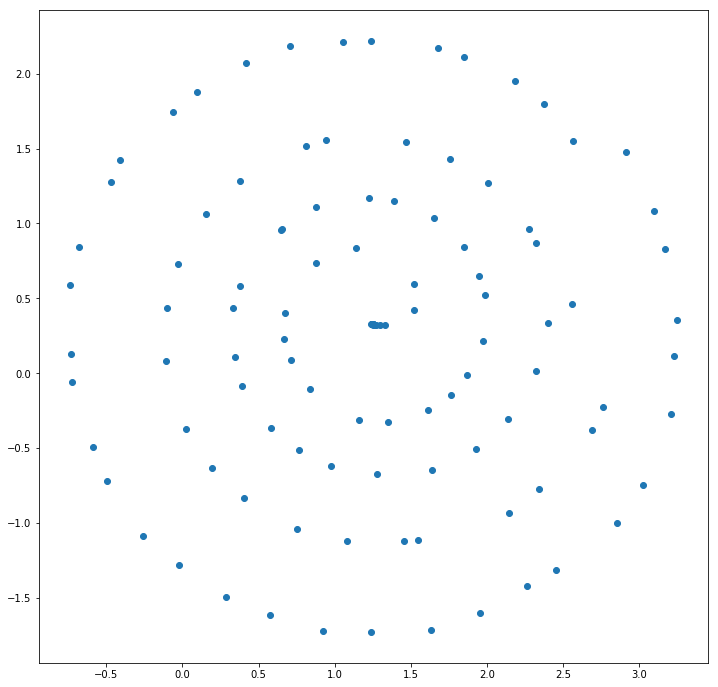

In [34]:
components=2
perp=30
n_iter=1000

tsne = TSNE(n_components=components, verbose=1, perplexity=perp, n_iter=n_iter)
tsne_results = tsne.fit_transform(melspec_reduced.T)
vis_x = tsne_results[:,0]
vis_y = tsne_results[:,1]
plt.figure(figsize=(12,12))
plt.scatter(vis_x, vis_y)
plt.show()

In [125]:
melspec.mean(), melspec.max(), melspec.min()

(5.402582, 4390.77, 6.824388e-14)

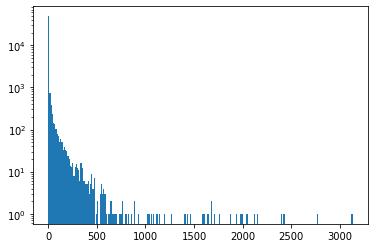

In [131]:
_ = plt.hist(melspec[:,:100].flatten(), bins=255, log=True)
plt.show()

In [126]:
im_arr.mean(), im_arr.max(), im_arr.min() # (4390/240)* = x/

(61.95579364931384, 240.0, 0.0)

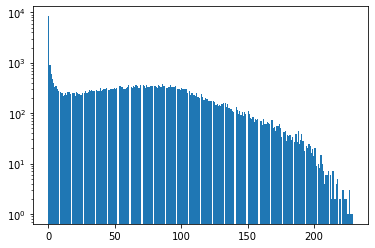

In [133]:
_ = plt.hist(im_arr[:,:100].flatten(), bins=255, log=True)
plt.show()

In [4]:
from PIL import Image

In [115]:
im_name = 'melspec2.png'
im = Image.open("images/%s" % im_name).convert('L')
im_arr = np.array(im, dtype=np.float64) #/ 255.0
im_arr = np.flipud(im_arr)

im_arr.shape

(512, 838)

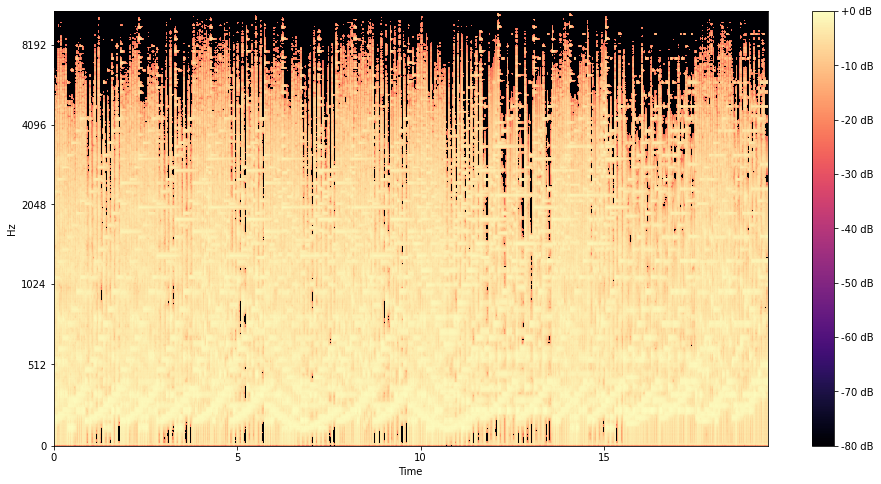

In [121]:
fig, ax = plt.subplots(figsize=(16,8))
im_arr_db = librosa.power_to_db(im_arr, ref=np.max)
#im_arr_db = librosa.amplitude_to_db(np.clip(im_arr - 0.01, 0.0, 1.0), ref=np.max)
img = librosa.display.specshow(im_arr_db, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [120]:
n_fft=2048
n_iter=32
sr=22050
pic_x = librosa.feature.inverse.mel_to_audio(im_arr*0.001, sr=sr, n_fft=n_fft, n_iter=n_iter)
sf.write('%s.wav' % im_name.split('.')[0], pic_x, sr, 'PCM_24')

array([[1.98782558e+01, 2.82042313e+01, 4.49855766e+01, ...,
        1.17969780e+02, 1.79809814e+02, 9.21373596e+01],
       [7.92953205e+00, 4.08772659e+01, 4.43190727e+01, ...,
        5.50593987e+01, 8.68599777e+01, 4.90137863e+01],
       [2.85805130e+01, 4.58418808e+01, 3.96407814e+01, ...,
        2.40057373e+01, 2.99134388e+01, 1.70094662e+01],
       ...,
       [3.11892092e-01, 2.30253696e-01, 1.72750145e-01, ...,
        4.65730131e-01, 3.73648763e-01, 2.68434554e-01],
       [1.24968655e-01, 1.59007579e-01, 1.18844137e-01, ...,
        2.55661041e-01, 2.07284138e-01, 1.75685361e-01],
       [1.67832021e-02, 2.29172613e-02, 1.65452212e-02, ...,
        2.07854975e-02, 2.31795181e-02, 2.54682563e-02]], dtype=float32)

array([[0.5       , 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.5       , 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.5       , 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ],
       ...,
       [0.5       , 0.5       , 0.54313725, ..., 0.5       , 0.5       ,
        0.5       ],
       [0.67647059, 0.55490196, 0.65294118, ..., 0.53529412, 0.5       ,
        0.5       ],
       [0.69215686, 0.53529412, 0.58235294, ..., 0.54313725, 0.53921569,
        0.5       ]])